
# Bayesian Survival Analysis: Mastectomy Data
This notebook demonstrates the `SurvivalAnalysis` workflow using a custom PyMC Cox model.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import sys
import os


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))


if project_root not in sys.path:
    sys.path.append(project_root)


from PyBH.SurvivalAnalysis.SurvivalAnalysis import SurvivalAnalysis
from PyBH.SurvivalAnalysis.pymc_models import Cox

c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(



### 1. Load Data
We use the Mastectomy dataset from the HSAUR R package.
It describes survival times of women with breast cancer, comparing those who received a mastectomy only vs. those who received mastectomy + radiotherapy.

In [2]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/HSAUR/mastectomy.csv"

df_raw = pd.read_csv(url, index_col=0)

# Verify the cleanup
print("Columns:", df_raw.columns.tolist())
print(df_raw.head())

Columns: ['time', 'event', 'metastized']
          time  event metastized
rownames                        
1           23   True         no
2           47   True         no
3           69   True         no
4           70  False         no
5          100  False         no



### 2. Define Cutpoints
The Bayesian Cox model uses a piecewise constant baseline hazard. We need to define the time intervals (cutpoints).
A good strategy is to use percentiles of the observed event times to ensure enough data in each interval.

In [3]:
n_intervals = 5
observed_times = df_raw['time'].values
cutpoints = np.percentile(observed_times[df_raw['event'] == 1], 
                          np.linspace(0, 100, n_intervals + 1)[1:-1])

print(f"Cutpoints: {cutpoints}")

Cutpoints: [23. 35. 50. 71.]



### 3. Initialize Model and Workflow
We create an instance of our PyMC `Cox` model and pass it to the `SurvivalAnalysis` manager.

In [4]:
cox_model = Cox(cutpoints=cutpoints, priors={"beta_sigma": 1.0})

analysis = SurvivalAnalysis(
    model=cox_model,
    data=df_raw,
    time_col="time",
    event_col="event",
    draws=2000,  
    tune=1000,
    chains=2,
    target_accept=0.9
)

   -> Mode: Bayesian (PyMC)


c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, lambda0]
c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may caus

c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### 4. Diagnostics
The `fit()` method has already run (inside the constructor of SurvivalAnalysis). 
We can now check the Bayesian traces.

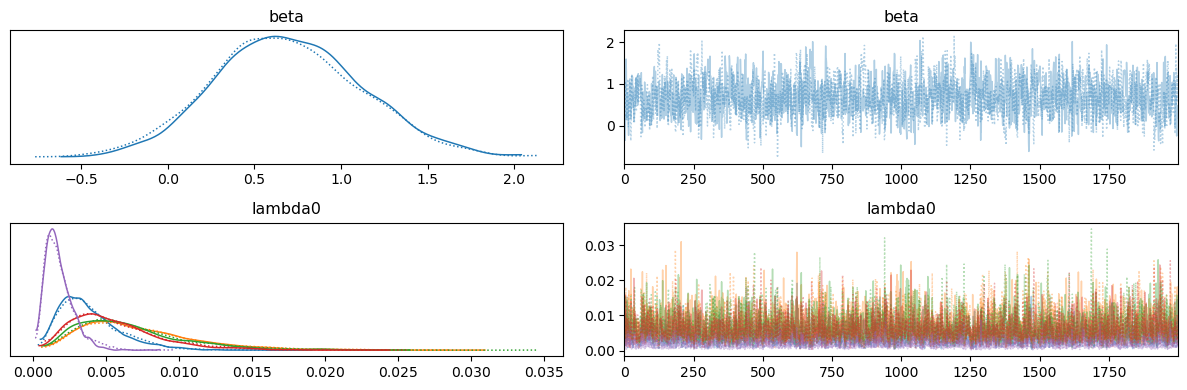

                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[metastized_yes]  0.692  0.429  -0.103    1.518      0.013    0.007   
lambda0[Int_0]        0.004  0.002   0.001    0.008      0.000    0.000   
lambda0[Int_1]        0.007  0.004   0.001    0.015      0.000    0.000   
lambda0[Int_2]        0.007  0.004   0.001    0.014      0.000    0.000   
lambda0[Int_3]        0.006  0.003   0.001    0.011      0.000    0.000   
lambda0[Int_4]        0.002  0.001   0.000    0.004      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
beta[metastized_yes]    1186.0    1630.0    1.0  
lambda0[Int_0]          1840.0    2906.0    1.0  
lambda0[Int_1]          1754.0    2518.0    1.0  
lambda0[Int_2]          1515.0    2170.0    1.0  
lambda0[Int_3]          1853.0    2473.0    1.0  
lambda0[Int_4]          1952.0    2471.0    1.0  


In [7]:
analysis.model.plot_traces()
print(analysis.model.summary())

### 5. Survival Curves
Let's plot the survival curves. Since `SurvivalAnalysis.plot_survival_function` 
currently plots a forest plot for coefficients, we can manually generate the survival curves 
using the `predict_survival_function` of our Cox class.

Features used: ['metastized_yes']


C:\Users\jeanv\AppData\Local\Temp\ipykernel_4112\764099985.py:22: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_A = az.hdi(surv_probs[:, 0, :], hdi_prob=0.95)
C:\Users\jeanv\AppData\Local\Temp\ipykernel_4112\764099985.py:28: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_B = az.hdi(surv_probs[:, 1, :], hdi_prob=0.95)


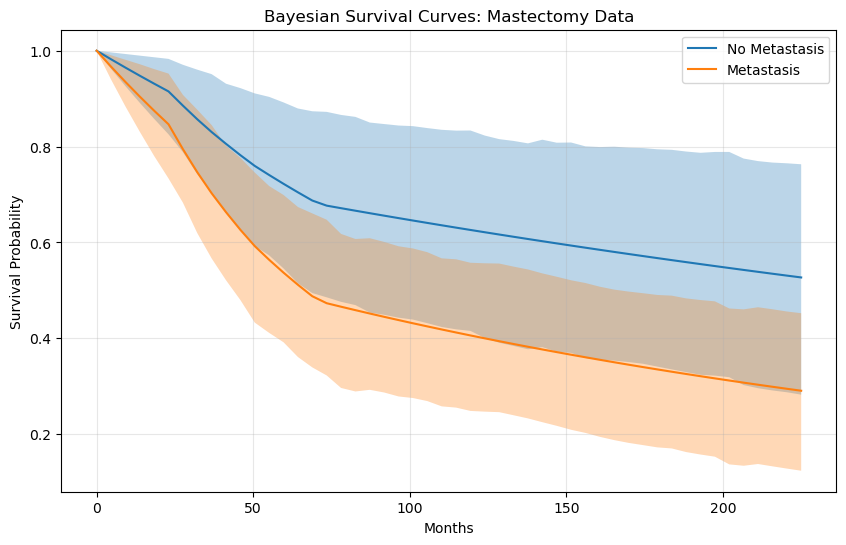

In [6]:
eval_times = np.linspace(0, df_raw.time.max(), 50)

# Create fake patients to compare: 
# Patient A: Metastasized = No (0)
# Patient B: Metastasized = Yes (1)
# Note: After one-hot encoding, check the column names in analysis.model._feature_names
print("Features used:", analysis.model._feature_names)

# Construct specific X matrix for prediction
# Assuming 'metastasized_yes' is the second column (index 1) after encoding
X_pred = np.array([
    [0], # Patient A (No metastasis)
    [1]  # Patient B (Metastasis)
])

surv_probs = analysis.model.predict_survival_function(X_pred, eval_times)

plt.figure(figsize=(10, 6))

# Plot Mean and 95% HDI for Patient A
mu_A = surv_probs[:, 0, :].mean(axis=0)
hdi_A = az.hdi(surv_probs[:, 0, :], hdi_prob=0.95)
plt.plot(eval_times, mu_A, label="No Metastasis")
plt.fill_between(eval_times, hdi_A[:,0], hdi_A[:,1], alpha=0.3)

# Plot Mean and 95% HDI for Patient B
mu_B = surv_probs[:, 1, :].mean(axis=0)
hdi_B = az.hdi(surv_probs[:, 1, :], hdi_prob=0.95)
plt.plot(eval_times, mu_B, label="Metastasis")
plt.fill_between(eval_times, hdi_B[:,0], hdi_B[:,1], alpha=0.3)

plt.title("Bayesian Survival Curves: Mastectomy Data")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()